## Решение для соревнования [SF-DST] Booking reviews

### Постановка задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

**Условия соревнования:**
* Данное соревнование является бессрочным и доступно для всех потоков.

* Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

* Тестовая выборка представлена в LeaderBoard целиком.

* Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

**Дополнительно**

Обратите внимание, что к данному соревнованию создано базовое решение:

### Метрика качества 
Результаты оцениваются по метрике MAPE ## Файл представления Для каждого **id** отеля в наборе тестовых данных вы должны предсказать рейтинг отеля для **reviewer_score** переменной. 

**Признаки**

* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


### 1. Импорт библиотек и подгрузка данных 

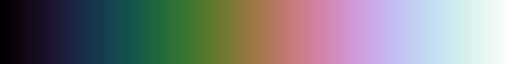

In [483]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

import category_encoders as ce
from sklearn import preprocessing 

from geopy.distance import great_circle  # Расчёт расстояния на основе координат

from sklearn.feature_selection import chi2,f_classif # хи-квадрат

from sklearn.model_selection import train_test_split # функция, чтобы разбить данные на тренировочные и тестовые
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
  
  

sns.set_theme('notebook')
sns.color_palette("cubehelix", as_cmap=True)

# pd.set_option('display.max_rows', None)  # Показывать все строки
# pd.set_option('display.max_columns', None)  # Показывать все колонки
# pd.set_option('display.width', None)  # Автоопределение ширины вывода
# pd.set_option('display.max_colwidth', None)  # Полная длина текста в ячейках


Подругрузка данных 

In [484]:
# Подгружаем данные 
df = pd.read_csv('data/hotels.csv')
city_centre = pd.read_csv('data/city_centre.csv')


In [485]:
display(df.info())
obj_len = len([x for x in df.columns if df[x].dtypes == 'object'])
print(f'В таблице {obj_len} не числовых признаков, и {df.shape[1] - obj_len} числовых')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

В таблице 8 не числовых признаков, и 9 числовых


#### Как можем видеть, в признаках долготы и широты (lng, lat) имеются пропуски
#### Помимо этого имеем 8 не числовых и 9 числовых признаков. Каждый из признаков будет рассмотрен далее. 

In [486]:
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


### 2. Очистка данных


2.1. Для начала проверим на наличие в таблице дубликатов, и удалим если таковы имеются.

In [487]:
print(f'В датасете дубликатов: {df[df.duplicated()].shape[0]} штук')
df.drop_duplicates(inplace=True)
print(f'После удаления дубликатов в датафрейме {df.shape[0]} строк')

В датасете дубликатов: 307 штук
После удаления дубликатов в датафрейме 386496 строк


2.2 Проверим сколько и какие признаки имеют пропуски

In [488]:
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633383
lng    0.633383
dtype: float64

In [489]:
display(df[df['lat'].isnull()].shape[0], df[df['lng'].isnull()].shape[0])

2448

2448

Видно, что lat и lng имеют одинаковый процент пропусков, дополнительно проверив, приходим к выводу, что во всех строках если пропуски имеются, то в обоих столбцах.

### 2.3 Заполнение пропущенных значений долготы и широты  

Для заполнения пустых значений столбцов **долготы** и **широты** было принято решение использовать бесплатный API от **Nominatim (OpenStreetMap)**.  

Запрос выполняется через библиотеку *requests*, отправляя HTTP-запрос по адресу отеля и получая на выходе координаты (долготу и широту).  

#### 🚨 Проблема  
Главной сложностью стало то, что пропущенных значений **много**, а API работает в **сингл-потоке**, что замедляет процесс.  

Однако, после детального анализа признаков выяснилось, что **из 2448 пропущенных значений всего 17 адресов уникальны**.  

#### ✅ Оптимизация  
Вместо того чтобы делать **2400+ одинаковых запросов**, можно **сгруппировать данные по адресу отеля** и применять функцию **только к уникальным значениям**.  

#### 📌 Итог  
- Вместо **2400 запросов** мы делаем всего **17**.  
- Все пропущенные данные заполняются.  
- Значительно сокращаем время обработки. 🚀  


In [490]:
df['lat_lng'] = (df.lng.isna()) & (df.lat.isna())
hotel_adress = df[df['lat_lng']].groupby(by = ['hotel_address','hotel_name']).count().iloc[:,0].reset_index()

geo_list = [48.83557774540167, 2.325449615375374], [48.88890917133979, 2.333131539489445],\
    [48.90646271737047, 2.286031792843036], [41.39161236219267, 2.177872539178857], [48.220880464073225, 16.366568581790354],\
    [48.23777955164721, 16.30049133008413], [48.2093946214496, 16.353391952955008], [48.209534571684244, 16.351474025963768],\
    [48.18885768730692, 16.383779297128065], [48.22291469050906, 16.393282694151672], [41.39267682257886, 2.1673975968485046],\
    [48.21960511317031, 16.28563501246867], [41.38479586582278, 2.1609370896181153], [48.24593013949892, 16.341821608782634],\
    [48.21368706024632, 16.379908197129218], [48.21681386879807, 16.359905697129335], [48.220438964319705, 16.355786410625193]

# геоданные в такой де последовательности, сделаем словарь
adres_geo_dict = {}

for a, h in zip(geo_list, list(hotel_adress['hotel_address'])):
    adres_geo_dict[h] = a

def get_geo(address, adres_geo_dict):
  if address in list(adres_geo_dict.keys()):
    return pd.Series([adres_geo_dict[address][0], adres_geo_dict[address][1]], index = ['lat','lng'])
df.loc[df[df['lat_lng']].index, ['lat','lng']] = df[df.lat.isna() | df.lng.isna()].loc[:].apply(lambda x: get_geo(x.hotel_address, adres_geo_dict), axis = 1)

df.drop('lat_lng', axis=1, inplace=True)

### 3. Исследование данных и создание новых признаков

**hotel_address**. По этому признаку были найдены пропущенные строки долготы и широты. Плюсом будет создать признак страны отеля, ведь во всех адресах города написаны в конце строки.

In [491]:
df['hotel_city'] = df['hotel_address'].apply(lambda x: x.split()[-5] if 'United Kingdom' in x else x.split()[-2])

df['hotel_city'].value_counts()


hotel_city
London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: count, dtype: int64

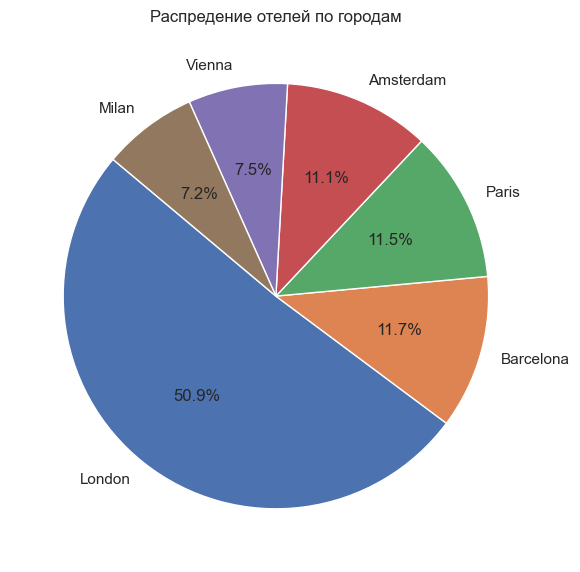

In [492]:
# Смотрим распределение отелей по городам
fig, axes = plt.subplots(figsize=(6, 6))
city_counts = df.hotel_city.value_counts()

plt.pie(
    city_counts,
    labels = city_counts.index,
    autopct='%1.1f%%',
    startangle=140
);

plt.title("Распредение отелей по городам")
plt.tight_layout()

По графику можно увидеть, что большая доля отелей в таблице находятся в Англии

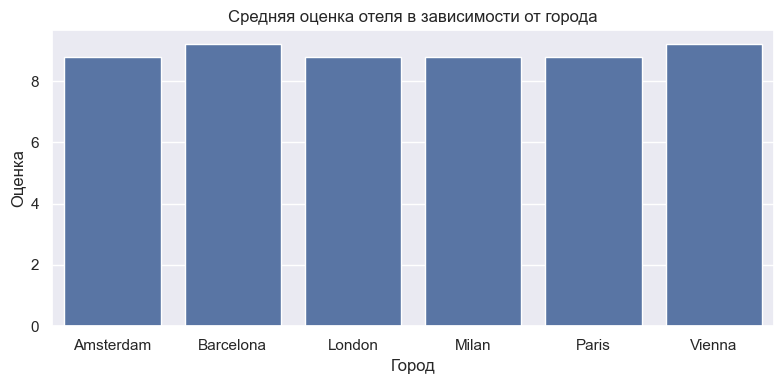

In [493]:
fig, axes = plt.subplots(figsize=(8, 4))

# Группируем по названию отеля и расчитываем медианную оценку
city_score = df.groupby('hotel_city')['reviewer_score'].median().reset_index()

# Строим барплот
sns.barplot(
    x=city_score.hotel_city, 
    y=city_score['reviewer_score'])

plt.title('Средняя оценка отеля в зависимости от города')
plt.xlabel('Город')
plt.ylabel('Оценка')
plt.tight_layout();

**hotel_name**. Что касается этого признака, ничего интересного думаю отсюда не вытащить, разве что количество слов или даже букв. Попробую вытащить количество слов в названии. Не думаю что количество слов в названии отеля как-то влияет на оценку отеля, но мало ли компьютер найдет закономерность :)

In [494]:
df['hotel_names_word_count'] = df['hotel_name'].apply(lambda x: len(x.split()))
df['hotel_names_word_count'].describe()

count    386496.000000
mean          3.929782
std           1.420139
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          11.000000
Name: hotel_names_word_count, dtype: float64

**days_since_review**. С этим признаком ничего особо делать не буду, просто оцифрую значения.

In [495]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))
df['days_since_review'].describe()

count    386496.000000
mean        354.339339
std         208.958145
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

**review_date**. Что касается даты размещения рецензентом отзыва, то просто разобью на подпризнаки 'года', 'месяца', и 'сезона года'.

Text(0.5, 1.0, 'Распределение получения данных по месяцам')

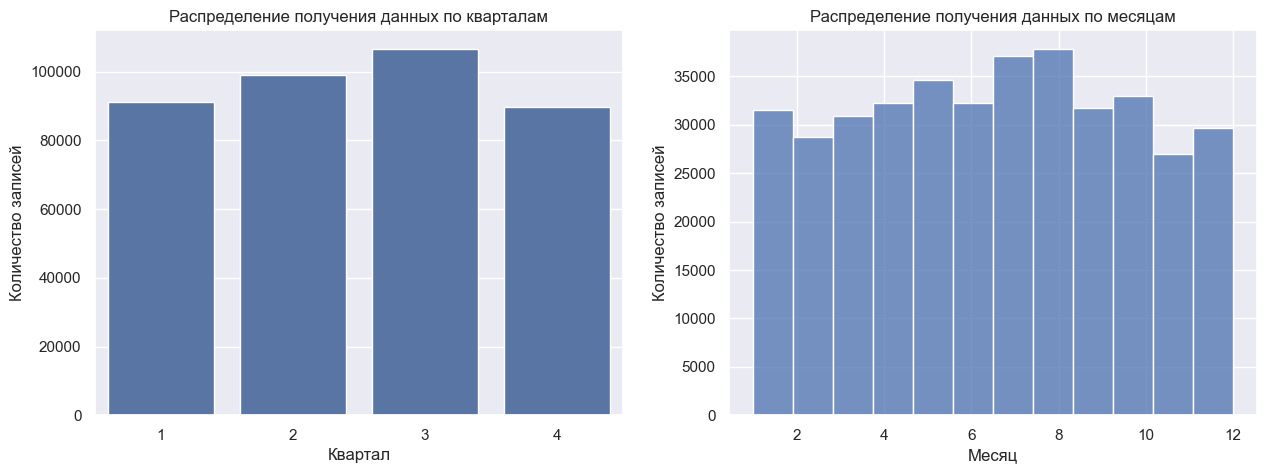

In [496]:
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['review_quarter'] = df['review_date'].dt.quarter
# df.drop('review_date', axis=1, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0] = sns.countplot(df, x='review_quarter', ax=axes[0])
axes[0].set(xlabel='Квартал', ylabel='Количество записей')
axes[0].set_title('Распределение получения данных по кварталам')

axes[1] = sns.histplot(df['review_month'], ax=axes[1], bins=12)
axes[1].set(xlabel='Месяц', ylabel='Количество записей')
axes[1].set_title('Распределение получения данных по месяцам')


На самом деле картина на интересная, судя по графику оценки оставлялись почти одинаково часто на всех период времени. Предпологаю, что эти признаки не будут супер полезными для модели. 

**neqative_review**. Предварительно рассмотрим признаки и пример решение по ним

In [497]:
display(df['negative_review'].head(10))
display(df['negative_review'].describe())

0                                             Leaving 
1                                       poor breakfast
2                                   No kettle in room 
3                                          No Negative
4                                         Torn sheets 
5                                              Nothing
6                               Nothing it was lovely 
7     The communal areas are a bit soul less and th...
8     undergoing refurbishment no tea coffer in roo...
9     I advised it was for my husbands birthday and...
Name: negative_review, dtype: object

count          386496
unique         248828
top       No Negative
freq            95833
Name: negative_review, dtype: object

В данных признаках можем увидеть варианты *'No Negative'* и *'Nothing'*. На основе них можно создать признак **non_neqative_review** если отзыв не несет негативного характера.

In [498]:
def negative_checker(col):
    non_neqative_words = ['no negative', 'nothing']
    for word in non_neqative_words:
        if word in col.lower():
            return 1
    return 0


df["non_negative_review"] = df['negative_review'].apply(negative_checker)

**positive_review**. Предварительно рассмотрим признаки и пример решение по ним

In [499]:
display(df['positive_review'].head(10))
display(df['positive_review'].describe())

0                                   Staff were amazing
1                                             location
2                                          No Positive
3     Friendly staff quiet comfortable room spotles...
4     The staff was very friendly and helpful Break...
5     Very nice hotel Price is excellent when compa...
6     Very central location 2 minutes walk from Glo...
7     The location is good for transport links espe...
8                  staff very good location wonderful 
9                                          No Positive
Name: positive_review, dtype: object

count          386496
unique         311737
top       No Positive
freq            26863
Name: positive_review, dtype: object

В данном признаке можем увидеть варианты *'No Positive'* и *'Nothing'* и *'Disaster'*. На основе них, можно создать признак **non_positive_review** если отзыв не несет положительного характера.

In [500]:
def positive_checker(col):
    non_neqative_words = ['no positive', 'nothing', 'disaster']
    for word in non_neqative_words:
        if word in col.lower():
            return 1
    return 0

df["non_positive_review"] = df['positive_review'].apply(positive_checker)
df["non_positive_review"].value_counts()

# df[['average_score', 'negative_review', 'positive_review']].sort_values(by='average_score',ascending=True)

non_positive_review
0    354652
1     31844
Name: count, dtype: int64

**reviewer_nationality**. Для начала рассмотрим признак

In [501]:
display(df['reviewer_nationality'].value_counts())
df[df['hotel_city'] == df['reviewer_nationality']]

reviewer_nationality
United Kingdom               183952
United States of America      26494
Australia                     16216
Ireland                       11119
United Arab Emirates           7612
                              ...  
Cook Islands                      1
Guinea                            1
Comoros                           1
Anguilla                          1
Grenada                           1
Name: count, Length: 225, dtype: int64

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,hotel_city,hotel_names_word_count,review_year,review_month,review_quarter,non_negative_review,non_positive_review


Как вариант был создать признак при совпадении стран рецензента и отеля, но таких совпадений не нашлось. Поэтому оставим признак как есть.

Добавлю также признак удаленности отеля от центра города

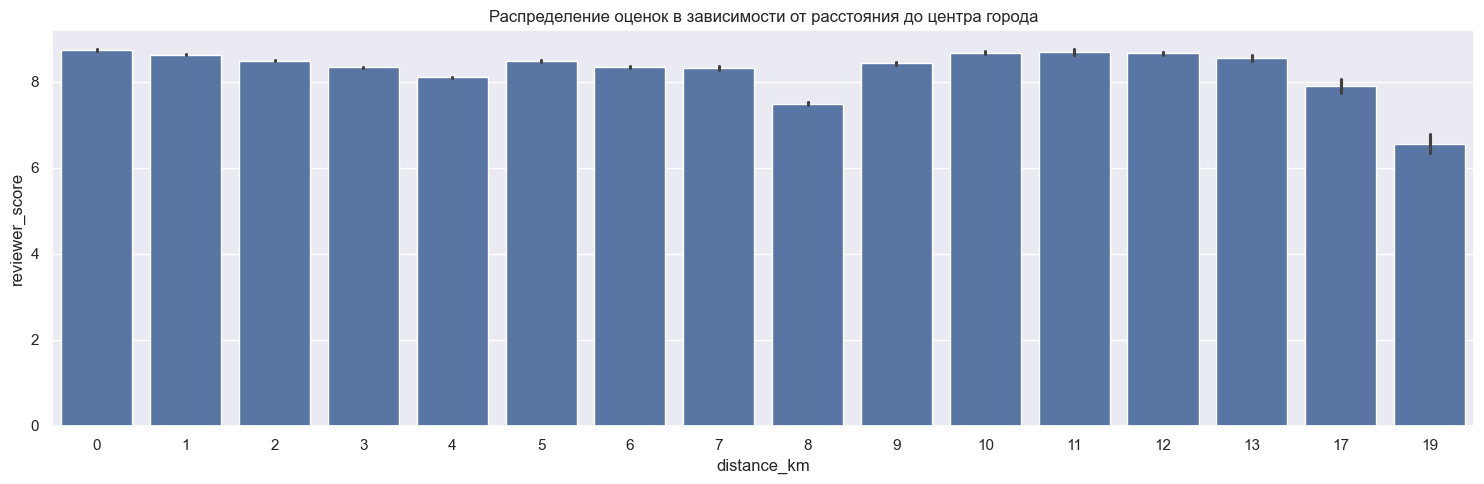

In [502]:
# Соединияем наш датафрейм с датафреймом координат точек городов и добавим суффкс _city
df = df.merge(city_centre, left_on='hotel_city', right_on='city', how='left', suffixes=('', '_c'))

df['distance_km'] = df.apply(lambda x: round(great_circle((x.lat_c, x.lng_c), (x.lat, x.lng)).kilometers), axis=1)

df.drop(['lat_c', 'lng_c', 'city'], axis=1, inplace=True)

ax = plt.figure(figsize=(15, 5))
sns.barplot(x=df.distance_km, y=df.reviewer_score)
plt.title('Распределение оценок в зависимости от расстояния до центра города')
plt.tight_layout();


На основе этого признака создадим признак того, хорошо ли распологается отель. Хорошим расположением будем считать удаленность от центра в пределах 2 км.

**tags**. Для начала рассмотрим признак, для последующих действий


In [503]:
display(df['tags'].describe(), df['tags'].head(3))

count                                                386496
unique                                                47135
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   3853
Name: tags, dtype: object

0    [' Leisure trip ', ' Couple ', ' Studio Suite ...
1    [' Business trip ', ' Couple ', ' Standard Dou...
2    [' Leisure trip ', ' Solo traveler ', ' Modern...
Name: tags, dtype: object

Признак максимально полезный, можно извлечь информацию об типе поездки(бизнес,отдых), количество дней прибывания в отеле, заселение в отель парой(семьей) или одному, и количество комнат(или 1 или 2).

In [504]:
def leisure_or_business_trip(col):
    col = list(map(lambda x: x.strip(), col[3:-3].split("', '")))
    if "Leisure" in col[0]:
        return 1
    elif "Business" in col[0]:
        return 0
    return 0


def double_or_single(col):
    col = list(map(lambda x: x.strip(), col[3:-3].split("', '")))
    for word in col:
        if 'Room' in word or 'Suite' in word:
            if 'Double' in word or 'Twin' in word:
                return 1 
            else: return 0 

def how_many_nights(col):
    col = list(map(lambda x: x.strip(), col[3:-3].split("', '")))
    for word in col:
        if 'Stayed' in word:
            return int(word.split()[1])
        else: 0 
        
        
def solo_or_couple(col):
    couple_words = ['couple', 'group', 'in' ,'family', 'with', 'children', 'other', 'older']
    col = list(map(lambda x: x.strip(), col[3:-3].split("', '")))
    def checker(col):
        for word in col:
            if word.lower() in couple_words:
                return 1
            else: return 0
        
    try: # на случай если в тагах всего 1 таг, тогда возьмем первый
        return checker(col[1].split())
    except IndexError: 
        return checker(col)


df['lazy_or_business_trip'] = df['tags'].apply(leisure_or_business_trip)
df['stayed_nights'] = df['tags'].apply(how_many_nights) 
df['couple_or_solo'] = df['tags'].apply(solo_or_couple)
df['double_or_single_room'] = df['tags'].apply(double_or_single)

df.info()

KeyboardInterrupt: 

Оказалось, что у некоторых тегов нет информации о комнатах. Так как пропущенных значений не много, заполню их медианой

In [ ]:
df['double_or_single_room'] = df['double_or_single_room'].fillna(df['double_or_single_room'].median())
# С признакам количества ночей та же картина.
df['stayed_nights'] = df['stayed_nights'].fillna(df['stayed_nights'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386496 non-null  object        
 1   additional_number_of_scoring                386496 non-null  int64         
 2   review_date                                 386496 non-null  datetime64[ns]
 3   average_score                               386496 non-null  float64       
 4   hotel_name                                  386496 non-null  object        
 5   reviewer_nationality                        386496 non-null  object        
 6   negative_review                             386496 non-null  object        
 7   review_total_negative_word_counts           386496 non-null  int64         
 8   total_number_of_reviews                     386496 non-null  int64        

#### **Промежуточные итоги**  

В результате нашей работы мы получили следующие признаки:  

- `hotel_country` - страна отеля

- `hotel_names_word_count`  - общее количество слов в названии отеля
- `review_year`  - год в котором была выстовлена оценка
- `review_month`  - месяц в котором была выставлена оценка
- `review_quarter`  - сезон в котором была выставлена оценка
- `non_negative_review`  - булевый признак негативности отзыва (нет негатива - 1, есть негатив - 0)
- `non_positive_review`  - булевый признак положительности отзыва (нет позитива - 1, есть позитив - 0)
- `lazy_or_business_trip`  - тип поездки (Leisure - 1, Business - 0)
- `stayed_nights`  - кол-во дней пребывания в отеле 
- `couple_or_solo`  - заселении в отель парой или одному (Пара(семья) - 1, Одиночка - 0)
- `double_or_single_room`  - кол-во комнат в отеле (2 комнаты - 1, 1 комната - 0)
- `distance_km`  - расстояния от отеля до центра города в км.

Признаки, из которых **выжаты все соки** и которые нам больше не нужны:  

- ~~`hotel_address`~~  

- ~~`hotel_name`~~  
- ~~`review_date`~~  
- ~~`negative_review`~~  
- ~~`positive_review`~~  
- ~~`tags`~~  

Теперь можно удалить ненужные признаки

In [ ]:
df.drop(['hotel_address', 'hotel_name', 'review_date', 'negative_review', 'positive_review', 'tags'], axis=1, inplace=True)

### 4. Кодирование признаков

В качестве кодировки выбор пал на Ordinal Encoder.

In [ ]:
# Изначально обозначим категориальные признаки
cat_cols = ['reviewer_nationality', 'hotel_city']
num_cols = [x for x in df.columns if (df[x].dtypes != 'object') and (x != 'reviewer_score')]

enco = ce.OrdinalEncoder()
data_bin = enco.fit_transform(df[cat_cols])
df.drop(cat_cols, axis=1, inplace=True)
df = pd.concat([df, data_bin], axis=1)


После кодирования категориальных признаков можно посмотреть на корреляцию между всеми признаками

<Axes: >

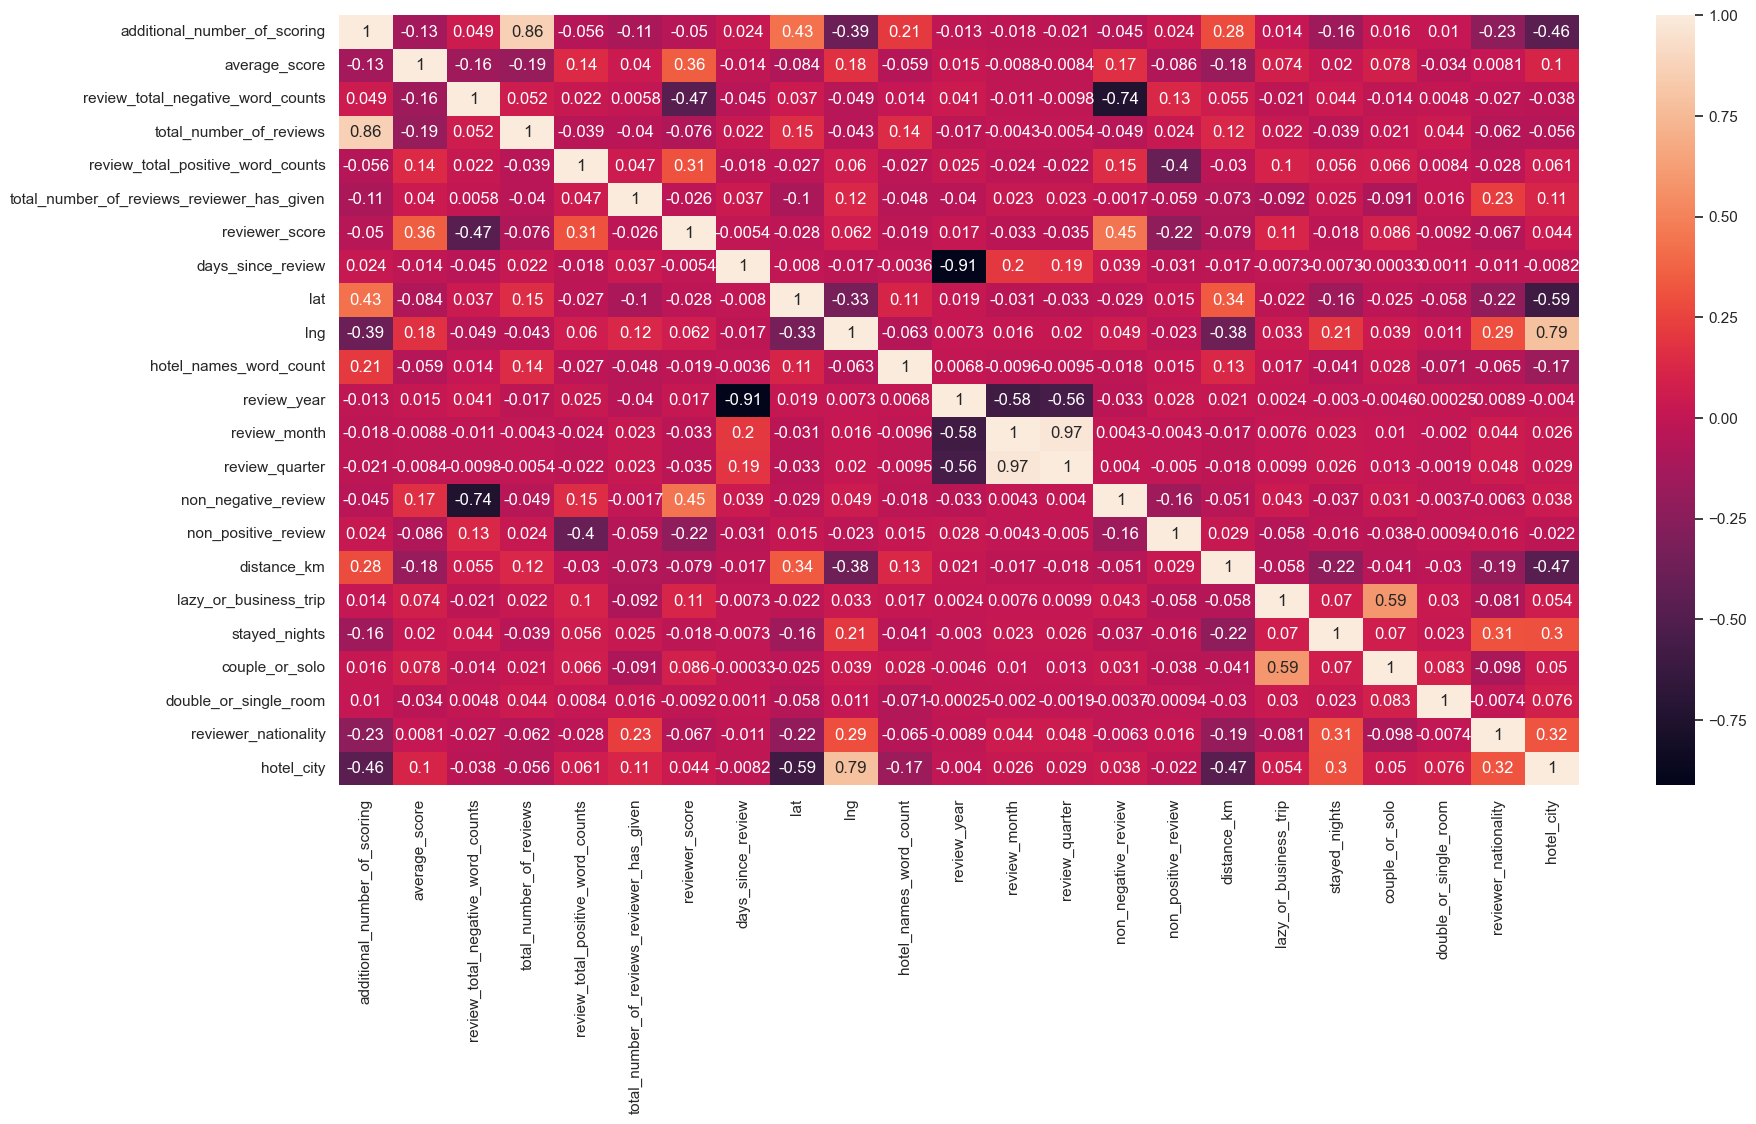

In [ ]:
ax = plt.figure(figsize=(20,10))
sns.heatmap(df.corr(method='spearman'), annot=True)

В глаза бросаются признаки 'review_month', 'total_number_of_reviews' и 'review_year'. Воспользуемся статистическими тестами для разбора важности признаков

In [ ]:
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   review_total_negative_word_counts           386496 non-null  int64  
 3   total_number_of_reviews                     386496 non-null  int64  
 4   review_total_positive_word_counts           386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 6   days_since_review                           386496 non-null  int64  
 7   lat                                         386496 non-null  float64
 8   lng                                         386496 non-null  float64
 9   hotel_names_word_count                      386496 non-null  int64  
 

<Axes: >

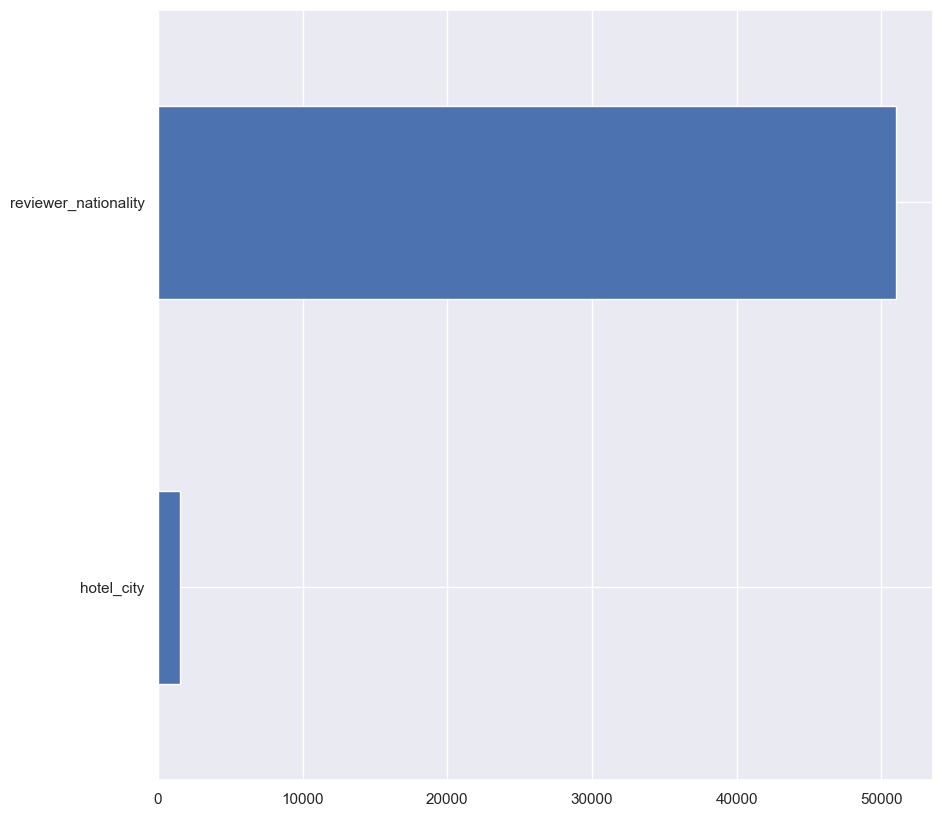

In [ ]:
imp_cat = pd.Series(chi2(X[cat_cols], y.astype('int'))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

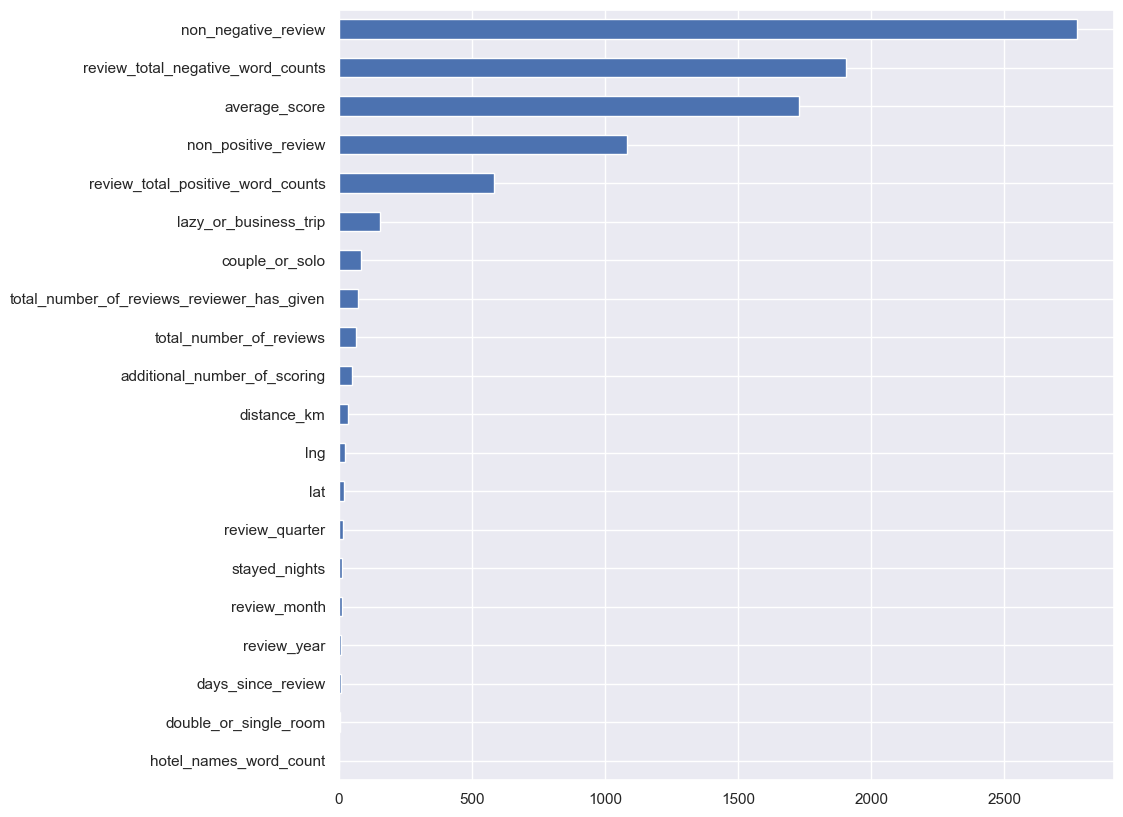

In [ ]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<Axes: >

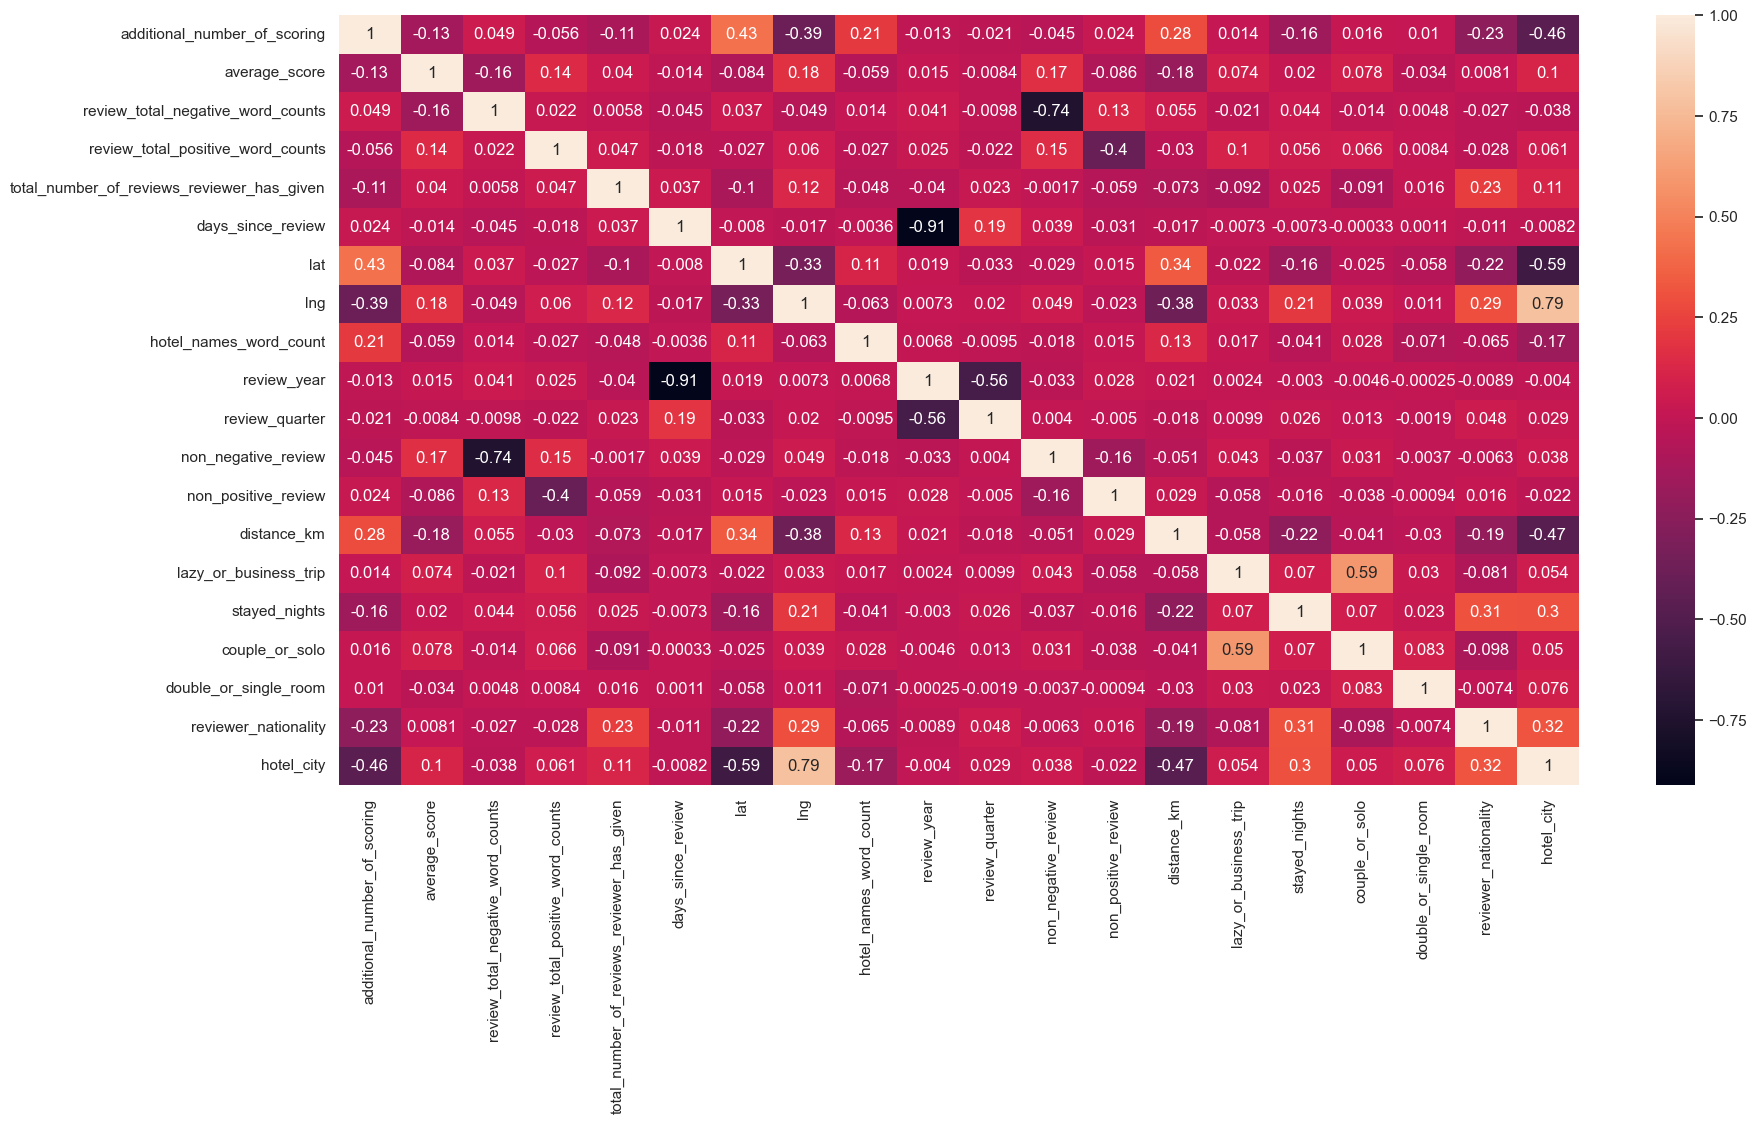

In [ ]:
droppable_cols = ['review_month', 'total_number_of_reviews']

X.drop(droppable_cols, axis=1, inplace=True)
ax = plt.figure(figsize=(20,10))
sns.heatmap(X.corr(method='spearman'), annot=True)

Прочитав о RandomForest узнал, что данный алгоритм не требует шкалирования данных, поэтому этот этап пропустим

### 5. Обучение модели



In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [ ]:
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13307819213500574


<Axes: >

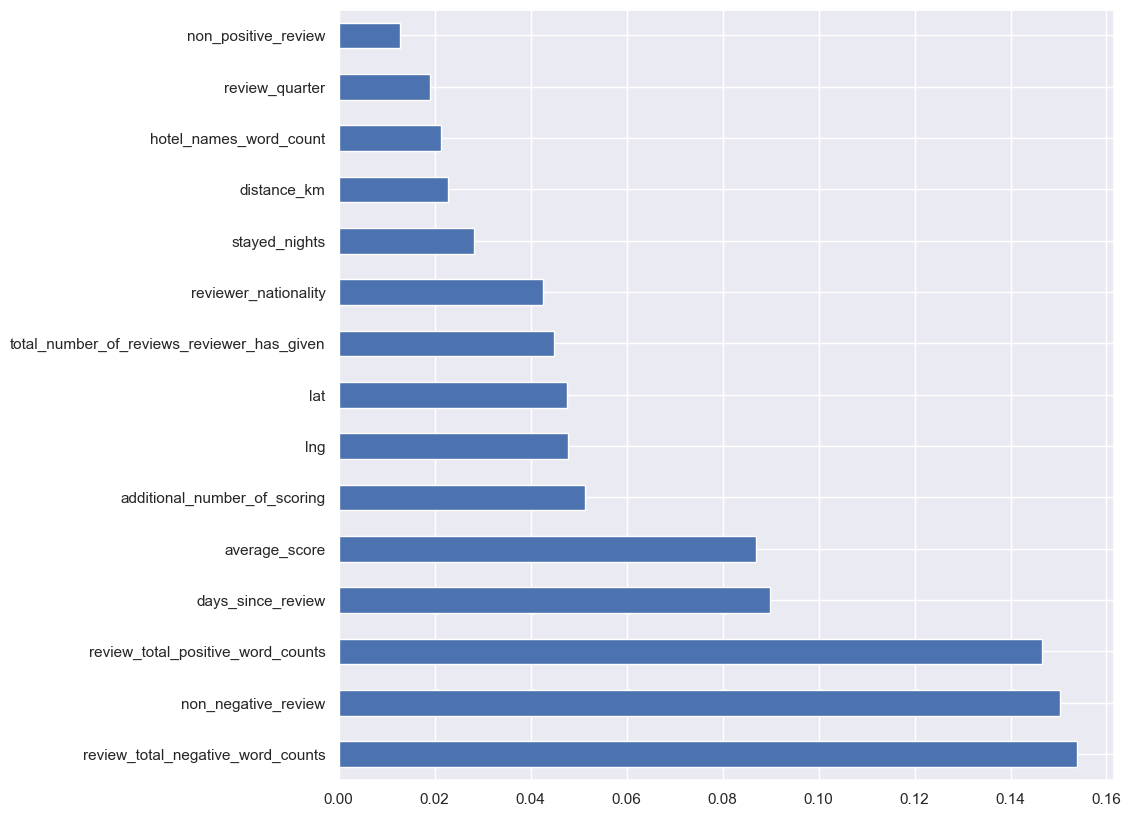

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')